In [51]:
from utils.database_connection import DatabaseConnection
import utils.results_repository as rep
import pandas as pd
import numpy as np
from utils.column_name_utils import *
import utils.query_utils as query
import matplotlib.pyplot as plot
import utils.dataframe_utils as df_util
import utils.path_utils as path_util
import utils.latex_utils as tex
import pandas as pd
from scipy.stats import shapiro, mannwhitneyu

In [52]:
db = DatabaseConnection()

Connected to MySQL Server version  8.0.32-24


In [53]:
measurements_used = 225
energy_per_time = 1000
generate_graphs = False

In [54]:
# exp_name = "compiler"
exp_name = "measuring_instrument"

In [55]:
used_dut_name = [
    'workstationone'
]

used_dut_name.sort()

used_dut_env = 'prod'

windows = "win32nt"
linux = "unix"

used_os_names = [
    windows, 
    # linux
]

used_test_case_names = [
    'fannkuch-redux.exe',
    'mandelbrot.exe'
]

used_test_case_names.sort()

used_thread = [
    'multi-threaded'
]

used_thread.sort()

used_test_case_name = 'idle-case.exe'

ipg = "ipg"
lhm = "lhm"
rapl = "rapl"
clamp = "clamp"
plug = "plug"
scaphandre = "scaphandre"

windows_mi = [
    ipg, lhm, clamp, plug, scaphandre
]

linux_mi = [
    rapl, clamp, plug
]

used_mi_names = [
    ipg, lhm, ipg, clamp, plug #, scaphandre, # plug, rapl
]

ipg_sample_rate = 100
lhm_sample_rate = 100
rapl_sample_rate = 100
clamp_sample_rate = 100
plug_sample_rate = 200
scaphandre_sample_rate = 100

used_min_temp = 0
used_max_temp = 200
used_burn_in = 1
used_allocated_cores = [
    []
]

used_allocated_cores.sort()

In [56]:
if exp_name == "compiler":
    experiment_name = "same-cpp-multi-core-micro-benchmark-different-compiler"
    experiment_number = 1
    
    used_mi_names = [
        ipg
    ]
    
    used_compilers = [
        'clang', 'intel-one-api', 'min-gw', 'msvc'
    ]
    
    test_case_parameters = ["", "12", "16000"]

if exp_name == "measuring_instrument":
    experiment_name = "same-one-api-compiler-different-measuring-instruments-post-update-and-watt"
    experiment_number = 2
    
    used_mi_names = [
        ipg, lhm, ipg, clamp, plug, scaphandre #, scaphandre, # plug, rapl
    ]
    
    used_compilers = [
        'intel-one-api'
    ]
    
    test_case_parameters = ["", "12", "64000"]


used_mi_names.sort()
used_compilers.sort()

In [57]:
used_dut_name_str = "','".join(used_dut_name)
used_os_name_str = "','".join(used_os_names)

In [58]:
dut = rep.get_devices_under_test(db)

dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod
1,2,workstationone,unix,prod
2,3,workstationone,unix,dev
3,4,workstationone,win32nt,dev


In [59]:
used_dut = dut.query(f"{ENV} == '{used_dut_env}' and {NAME} in ('{used_dut_name_str}') and Os in ('{used_os_name_str}')")

used_dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod


In [60]:
tc = rep.get_test_cases(db)

tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
0,1,fannkuch-redux.exe,clang,c++,-openmp,microbenchmarks,12,multi-threaded
1,2,mandelbrot.exe,clang,c++,-openmp,microbenchmarks,16000,multi-threaded
2,3,idle-case.exe,clang,c++,-openmp,microbenchmarks,,multi-threaded
3,4,fannkuch-redux.exe,intel-one-api,c++,-openmp,microbenchmarks,12,multi-threaded
4,5,mandelbrot.exe,intel-one-api,c++,-openmp,microbenchmarks,16000,multi-threaded
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded
6,7,fannkuch-redux.exe,min-gw,c++,-openmp,microbenchmarks,12,multi-threaded
7,8,mandelbrot.exe,min-gw,c++,-openmp,microbenchmarks,16000,multi-threaded
8,9,idle-case.exe,min-gw,c++,-openmp,microbenchmarks,,multi-threaded
9,10,fannkuch-redux.exe,msvc,c++,-openmp,microbenchmarks,12,multi-threaded


In [61]:
used_test_case_name_str = "','".join(used_test_case_names)
used_compiler_str = "','".join(used_compilers)
used_thread_str = "','".join(used_thread)
used_test_case_parameters = "','".join(test_case_parameters)

used_tc = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} in ('{used_test_case_name_str}') and {THREADS} in ('{used_thread_str}') and Parameter in ('{used_test_case_parameters}')")

In [62]:
used_idle_case = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} == '{used_test_case_name}' and {THREADS} in ('{used_thread_str}')")

In [63]:
mi = rep.get_measuring_instruments(db)

mi

,Id,Name,SampleRate
0,1,ipg,100
1,2,lhm,100
2,3,clamp,100
3,4,rapl,100
4,5,clamp,500
5,6,scaphandre,100
6,7,plug,100
7,8,plug,200


In [64]:
used_mi_query_list = []

if ipg in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{ipg}' and {SAMPLE_RATE} == {ipg_sample_rate})")

if lhm in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{lhm}' and {SAMPLE_RATE} == {lhm_sample_rate})")

if rapl in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{rapl}' and {SAMPLE_RATE} == {rapl_sample_rate})")


if plug in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{plug}' and {SAMPLE_RATE} == {plug_sample_rate})")

if clamp in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{clamp}' and {SAMPLE_RATE} == {clamp_sample_rate})")
    
if scaphandre in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{scaphandre}' and {SAMPLE_RATE} == {scaphandre_sample_rate})")

used_mi = mi.query(" or ".join(used_mi_query_list))

In [65]:
used_allocated_cores_str = "','".join([str(x) for x in used_allocated_cores])

In [66]:
config = rep.get_configurations(db)

config

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]
1,2,0,200,0,[1]
2,3,0,200,0,"[0, 1, 2, 3]"
3,4,0,200,0,"[0, 1, 2, 3, 4, 5, 6, 7]"


In [67]:
used_configs = config.query(f"{MIN_TEMP} == {used_min_temp} and " +
                            f"{MAX_TEMP} == {used_max_temp} and " +
                            f"{BURN_IN} == {used_burn_in} and " +
                            f"{ALLOCATED_CORES} in ('{used_allocated_cores_str}')")

In [68]:
exp = rep.get_distinct_experiments(db)

exp

,Experiment,Name
0,1,same-cpp-multi-core-micro-benchmark-different-...
1,1,test
2,1,same-one-api-compiler-different-measuring-inst...
3,1,same-one-api-compiler-different-measuring-inst...
4,2,same-one-api-compiler-different-measuring-inst...


In [69]:
used_dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod


In [70]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
3,4,fannkuch-redux.exe,intel-one-api,c++,-openmp,microbenchmarks,12,multi-threaded
18,22,mandelbrot.exe,intel-one-api,c++,-openmp,microbenchmarks,64000,multi-threaded


In [71]:
used_mi

,Id,Name,SampleRate
0,1,ipg,100
1,2,lhm,100
2,3,clamp,100
5,6,scaphandre,100
7,8,plug,200


In [72]:
used_idle_case

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded


In [73]:
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]


In [74]:
cpu_energy_results = {}
dram_energy_results = {}
gpu_energy_results = {}
duration_results = {}

cpu_dynamic_energy_consumption = {}
gpu_dynamic_energy_consumption = {}
dram_dynamic_energy_consumption = {}

for dut_index, dut_row in used_dut.iterrows():
    dut_id = dut_row[ID]
    dut_name = dut_row[NAME]
    dut_os = dut_row[OS]
    for mi_index, mi_row in used_mi.iterrows():
        mi_id = mi_row[ID]
        mi_name = mi_row[NAME]
        
        if dut_os == windows and not mi_name in windows_mi:
            continue
        
        if dut_os == linux and not mi_name in linux_mi:
            continue
        
        for config_index, config_row in used_configs.iterrows():
            config_id = config_row[ID]
            config_cores = config_row[ALLOCATED_CORES]
            if config_cores == "[]":
                config_cores = 'all'
            for tc_index, tc_row in used_tc.iterrows():
                tc_id = tc_row[ID]
                tc_name = tc_row[NAME]
                tc_compiler = tc_row[COMPILER]
                tc_language = tc_row[LANGUAGE]
                tc_optimizations = tc_row[OPTIMIZATIONS]
                tc_test_case_size = tc_row[TEST_CASE_SIZE]
                tc_threads = tc_row[THREADS]
                
                tc_idle_case = query.get_idle_case(used_idle_case, tc_compiler, tc_language, tc_optimizations, tc_test_case_size, tc_threads)
                tc_idle_case_id =int(tc_idle_case[ID].iloc[0])
                
                tc_collection = rep.get_collections(db, dut_id, mi_id, config_id, tc_id, experiment_name, experiment_number)
                tc_idle_case_collection = rep.get_collections(db, dut_id, mi_id, config_id, tc_idle_case_id, experiment_name, experiment_number)
                
                tc_collection_id = int(tc_collection[ID].iloc[0])
                tc_idle_case_collection_id = int(tc_idle_case_collection[ID].iloc[0])
                
                tc_measurements = rep.get_measurements(db, tc_collection_id)
                tc_idle_case_measurements = rep.get_measurements(db, tc_idle_case_collection_id)
                
                key = f"{tc_name}.{mi_name}.{dut_name}.{config_cores}.{tc_compiler}.{dut_os}"
                
                dram_energy_results[key] = list(tc_measurements["DramEnergyInJoules"])
                cpu_energy_results[key] = list(tc_measurements["CpuEnergyInJoules"])
                gpu_energy_results[key] = list(tc_measurements["GpuEnergyInJoules"])
                duration_results[key] = list(tc_measurements["Duration"])
                
                idle_cpu_consumption = df_util.get_cpu_energy_per_time(tc_idle_case_measurements, energy_per_time)
                idle_gpu_consumption = df_util.get_gpu_energy_per_time(tc_idle_case_measurements, energy_per_time)
                idle_dram_consumption = df_util.get_dram_energy_per_time(tc_idle_case_measurements, energy_per_time)
                
                cpu_dynamic_energy_consumption[key] = df_util.get_cpu_dynamic_energy(tc_measurements, idle_cpu_consumption, energy_per_time)
                gpu_dynamic_energy_consumption[key] = df_util.get_gpu_dynamic_energy(tc_measurements, idle_gpu_consumption, energy_per_time)
                dram_dynamic_energy_consumption[key] = df_util.get_dram_dynamic_energy(tc_measurements, idle_dram_consumption, energy_per_time)

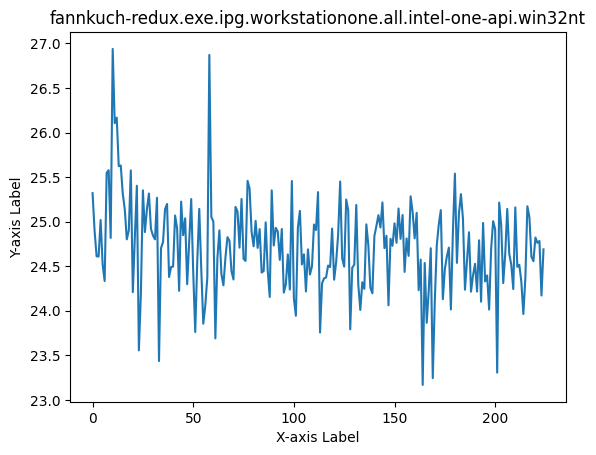

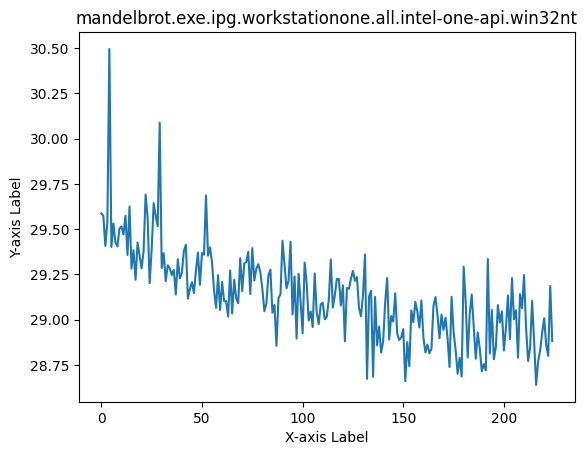

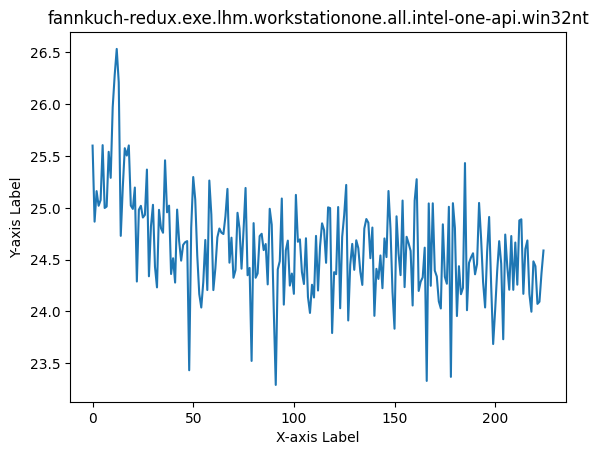

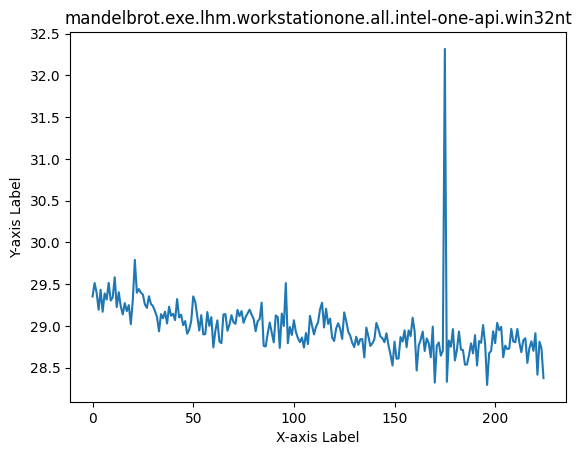

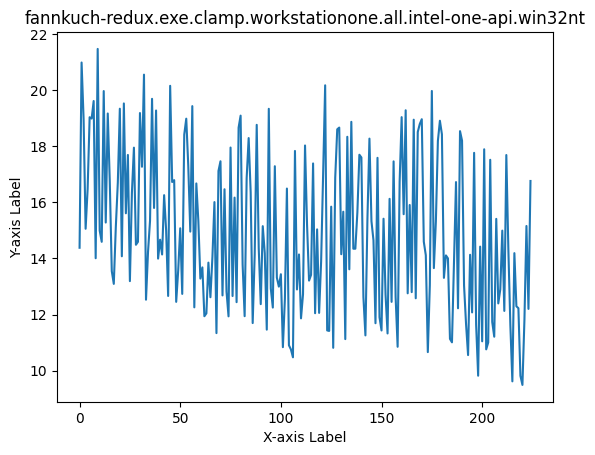

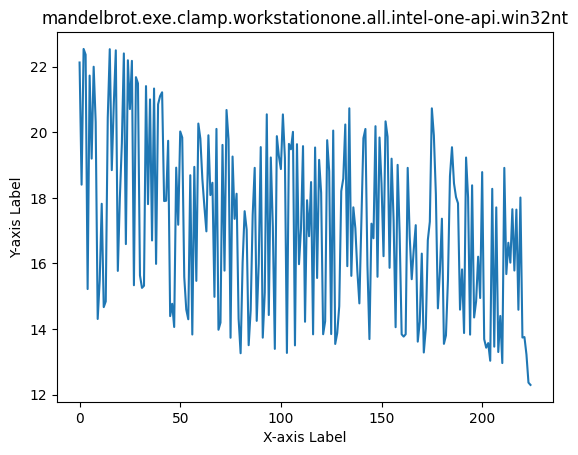

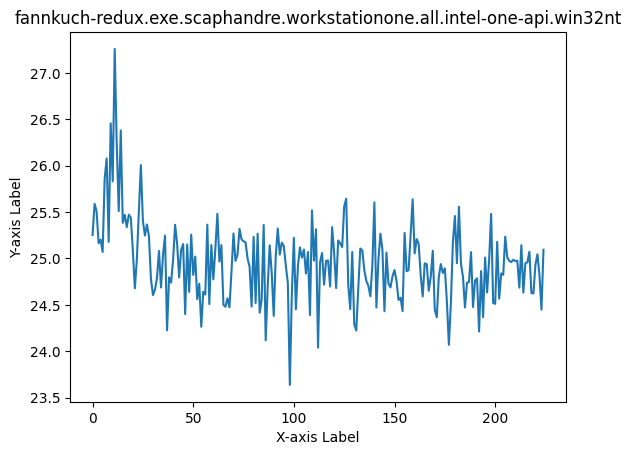

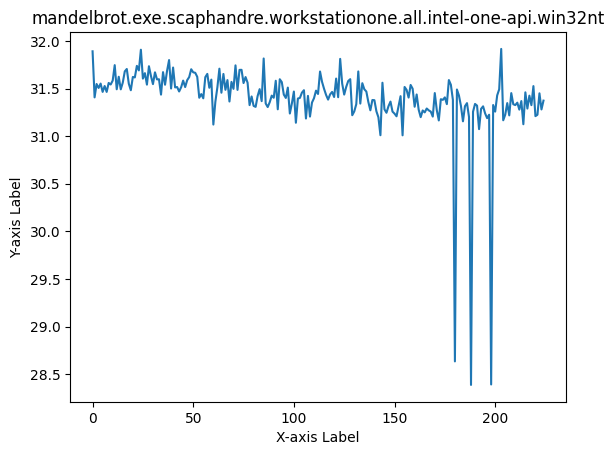

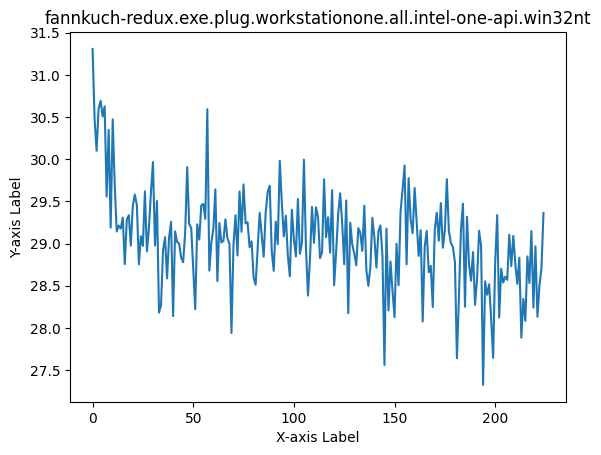

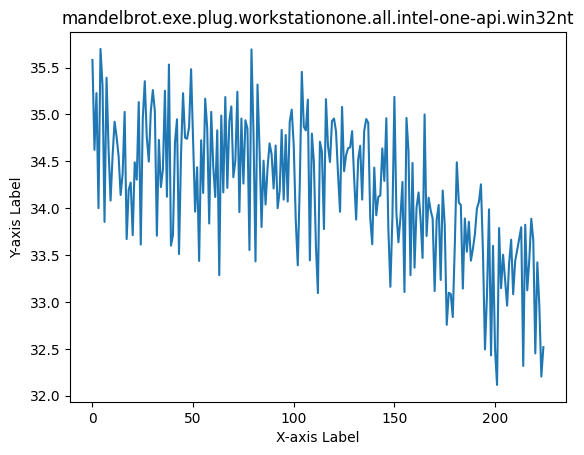

In [92]:

for p in cpu_dynamic_energy_consumption:
    x_values = range(len(cpu_dynamic_energy_consumption[p]))

    # plot the graph
    plot.plot(x_values, cpu_dynamic_energy_consumption[p])

    # add a title and labels
    plot.title(p)
    plot.xlabel("X-axis Label")
    plot.ylabel("Y-axis Label")

    # display the graph
    plot.show()

In [76]:
config_cores == "[]"
for key, value in dram_energy_results.items():
    dram_energy_results[key] = value[:measurements_used]
    
for key, value in cpu_energy_results.items():
    cpu_energy_results[key] = value[:measurements_used]

for key, value in gpu_energy_results.items():
    gpu_energy_results[key] = value[:measurements_used]

for key, value in duration_results.items():
    duration_results[key] = value[:measurements_used]
    
for key, value in cpu_dynamic_energy_consumption.items():
    cpu_dynamic_energy_consumption[key] = value[:measurements_used]

for key, value in gpu_dynamic_energy_consumption.items():
    gpu_dynamic_energy_consumption[key] = value[:measurements_used]
    
for key, value in dram_dynamic_energy_consumption.items():
    dram_dynamic_energy_consumption[key] = value[:measurements_used]

In [77]:
## Energy consumption for the entire test case
dram_df = pd.DataFrame(dram_energy_results)
dram_df =dram_df.reindex(columns=sorted(dram_df.columns))

cpu_df = pd.DataFrame(cpu_energy_results)
cpu_df = cpu_df.reindex(columns=sorted(cpu_df.columns))

gpu_df = pd.DataFrame(gpu_energy_results)
gpu_df = gpu_df.reindex(columns=sorted(gpu_df.columns))

duration_df = pd.DataFrame(duration_results)
duration_df = duration_df.reindex(columns=sorted(duration_df.columns))

## Dynamic energy data frames
dram_dynamic_df = pd.DataFrame(dram_dynamic_energy_consumption)
dram_dynamic_df = dram_dynamic_df.reindex(columns=sorted(duration_df.columns))

cpu_dynamic_df = pd.DataFrame(cpu_dynamic_energy_consumption)
cpu_dynamic_df = cpu_dynamic_df.reindex(columns=sorted(cpu_dynamic_df.columns))

gpu_dynamic_df = pd.DataFrame(gpu_dynamic_energy_consumption)
gpu_dynamic_df = gpu_dynamic_df.reindex(columns=sorted(gpu_dynamic_df.columns))

In [78]:
cpu_dynamic_df

,fannkuch-redux.exe.clamp.workstationone.all.intel-one-api.win32nt,fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt,fannkuch-redux.exe.lhm.workstationone.all.intel-one-api.win32nt,fannkuch-redux.exe.plug.workstationone.all.intel-one-api.win32nt,fannkuch-redux.exe.scaphandre.workstationone.all.intel-one-api.win32nt,mandelbrot.exe.clamp.workstationone.all.intel-one-api.win32nt,mandelbrot.exe.ipg.workstationone.all.intel-one-api.win32nt,mandelbrot.exe.lhm.workstationone.all.intel-one-api.win32nt,mandelbrot.exe.plug.workstationone.all.intel-one-api.win32nt,mandelbrot.exe.scaphandre.workstationone.all.intel-one-api.win32nt
0,14.379369,25.319667,25.600858,31.307388,25.253087,22.125562,29.587276,29.352284,35.581528,31.891643
1,20.978909,24.896763,24.866785,30.477037,25.589230,18.400991,29.574935,29.513727,34.622722,31.407511
2,18.963978,24.610360,25.161629,30.099896,25.506860,22.539837,29.408009,29.399821,35.228391,31.548106
3,15.056077,24.608356,25.020075,30.601631,25.165043,22.366093,29.537566,29.193040,34.000794,31.506666
4,16.468357,25.018258,25.075692,30.692303,25.203682,15.218229,30.495959,29.432863,35.699249,31.552547
...,...,...,...,...,...,...,...,...,...,...
220,9.492342,24.821891,24.437038,28.967087,24.932711,13.739545,29.008605,28.912125,32.450908,31.210572
221,11.823586,24.761644,24.073184,28.132669,25.045824,13.753707,28.861468,28.414889,33.422223,31.224700
222,15.154735,24.782603,24.094267,28.501754,24.819411,13.220894,28.801048,28.810543,32.959805,31.450181
223,12.200534,24.170511,24.366441,28.711660,24.448455,12.365215,29.186627,28.730803,32.204191,31.280611


In [117]:
def Mann(dataFrame):
    results = {}
    for i, col1 in enumerate(dataFrame):
        results[col1] = {}
        for j, col2 in enumerate(dataFrame):
            if i <= j:  # only compare unique pairs of columns
                stat, p = mannwhitneyu(dataFrame[col1], dataFrame[col2])
                alpha = 0.05
                results[col1][col2] = p
                # interpret the result
                if p > alpha:
                    print(f"{col1} and {col2} have similar medians")
                else:
                    print(f"{col1} and {col2} have significantly different medians")
    return results

def Kendall(truthFrame,dataFrame):
    results = {}
    print(f"Kendall's correlation coefficients for {dataFrame.columns[0].split('.')[0]}:")
    for i, col1 in enumerate(dataFrame):
        results[col1] = {}
        for j, col2 in enumerate(truthFrame):
            # only compare unique pairs of columns
            corr = dataFrame[col1].corr(dataFrame[col2], method='kendall')
            print(f"{col1} and {col2}: {corr:.3f}")
            results[col1][col2] = corr
    print()

def Sharpiro(dataFrame):
    results = {}
    for col in dataFrame.columns:
        stat, p = shapiro(cpu_dynamic_df[col])
        alpha = 0.05
        results[col] = p
        # interpret the result
        if p > alpha:
            print(f'{col} is normally distributed')
        else:
            print(f'{col} is not normally distributed')

In [118]:
fannkuch_df = cpu_dynamic_df.filter(regex='fannkuch-redux')
mandelbrot_df = cpu_dynamic_df.filter(regex='mandelbrot')


truthFann = fannkuch_df.filter(regex='clamp')
truthMand = mandelbrot_df.filter(regex='clamp')
DiffrenceFannkuch = Mann(fannkuch_df)
DiffrenceMandelbrot = Mann(mandelbrot_df)
CorrelationFannkuch = Kendall(truthFann,fannkuch_df)
CorrelationMandelbrot = Kendall(truthMand, mandelbrot_df)
# print(fannkuch_df)

fannkuch-redux.exe.clamp.workstationone.all.intel-one-api.win32nt and fannkuch-redux.exe.clamp.workstationone.all.intel-one-api.win32nt have similar medians
fannkuch-redux.exe.clamp.workstationone.all.intel-one-api.win32nt and fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt have significantly different medians
fannkuch-redux.exe.clamp.workstationone.all.intel-one-api.win32nt and fannkuch-redux.exe.lhm.workstationone.all.intel-one-api.win32nt have significantly different medians
fannkuch-redux.exe.clamp.workstationone.all.intel-one-api.win32nt and fannkuch-redux.exe.plug.workstationone.all.intel-one-api.win32nt have significantly different medians
fannkuch-redux.exe.clamp.workstationone.all.intel-one-api.win32nt and fannkuch-redux.exe.scaphandre.workstationone.all.intel-one-api.win32nt have significantly different medians
fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt and fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt have similar median

In [116]:
print(DiffrenceFannkuch)


{'fannkuch-redux.exe.clamp.workstationone.all.intel-one-api.win32nt': {'fannkuch-redux.exe.clamp.workstationone.all.intel-one-api.win32nt': 1.0, 'fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt': 3.2749738952050108e-75, 'fannkuch-redux.exe.lhm.workstationone.all.intel-one-api.win32nt': 3.2749738952050108e-75, 'fannkuch-redux.exe.plug.workstationone.all.intel-one-api.win32nt': 3.2749738952050108e-75, 'fannkuch-redux.exe.scaphandre.workstationone.all.intel-one-api.win32nt': 3.2749738952050108e-75}, 'fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt': {'fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt': 1.0, 'fannkuch-redux.exe.lhm.workstationone.all.intel-one-api.win32nt': 0.016443299424697147, 'fannkuch-redux.exe.plug.workstationone.all.intel-one-api.win32nt': 3.2749738952050108e-75, 'fannkuch-redux.exe.scaphandre.workstationone.all.intel-one-api.win32nt': 1.3401735521987104e-08}, 'fannkuch-redux.exe.lhm.workstationone.all.intel-one-api.win32